<a href="https://colab.research.google.com/github/inkosii/ESK20233-Model/blob/main/EskomModel_And_Bias_Audit_Sinenhlahla_Q_Nkosi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Eskom Residual Electricity Demand Forecasting  
### *Data Preprocessing • EDA • Feature Engineering • Model Training • Evaluation And Bias Audit*

**Author:** Sinenhlahla Qiniso Nkosi  
**Affiliation:** Capaciti
**Date:** 3 December 2025

---


In [3]:
from IPython.display import Javascript

Javascript("""
(() => {
  const metadata = Jupyter.notebook.metadata;
  metadata['authors'] = [{'name': 'Sinenhlahla Qiniso Nkosi'}];
  Jupyter.notebook.set_dirty();
})();
""")


<IPython.core.display.Javascript object>

In [48]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ESK2033.csv')

# -------------------------------------------------------------
# Fixing the Datetime Column
# -------------------------------------------------------------
# The original 'Date Time Hour Beginning' column is misparsed by
# pd.to_datetime and defaults to 1970-01-01 timestamps.
# Since this dataset represents hourly electricity demand,
# I decided to reconstruct a clean hourly DatetimeIndex manually.
#
# I assume the dataset begins on 2018-04-01 at 00:00 and continues
# at hourly frequency for the full length of the CSV.
# -------------------------------------------------------------

start_date = '2018-04-01 00:00:00'
num_rows = len(df)

# Create a correctly formatted hourly DatetimeIndex
new_index = pd.date_range(start=start_date, periods=num_rows, freq='h')

# Assign it to the DataFrame
df = df.set_index(new_index)
df.index.name = 'Date_Time_Hour_Beginning'

# -------------------------------------------------------------
# Clean Up Original Columns
# -------------------------------------------------------------
# If the original datetime column still exists, I drop it to
# prevent conflicts with dtype inference later in the workflow.
# -------------------------------------------------------------
if 'Date Time Hour Beginning' in df.columns:
    df = df.drop(columns=['Date Time Hour Beginning'])

# -------------------------------------------------------------
# Standardize Column Names
# -------------------------------------------------------------
# For consistency (especially with LightGBM), I replace spaces
# with underscores so that feature names are clean and uniform.
# -------------------------------------------------------------
df.columns = df.columns.str.replace(' ', '_')

# -------------------------------------------------------------
# Final Index Cleanup
# -------------------------------------------------------------
# I make sure the index is sorted and free of duplicates to avoid
# issues when resampling or joining with other time-based features.
# -------------------------------------------------------------
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

# Display a sample of the cleaned dataset
df.head(10)


,Original_Res_Forecast_before_Lockdown,Residual_Forecast,RSA_Contracted_Forecast,Dispatchable_Generation,Residual_Demand,RSA_Contracted_Demand,International_Exports,International_Imports,Thermal_Generation,Nuclear_Generation,...,Total_RE_Installed_Capacity,Installed_Eskom_Capacity,Total_PCLF,Total_UCLF,Total_OCLF,Total_UCLF+OCLF,Non_Comm_Sentout,Drakensberg_Gen_Unit_Hours,Palmiet_Gen_Unit_Hours,Ingula_Gen_Unit_Hours
Date_Time_Hour_Beginning,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,19904.967,20367.066,20237.0,20237.0,20722.058,1215.902,1120.0,19444.0,931.0,0.0,...,44546.0,3987.472,8028.710,275.907,8304.0,617.0,383.0,81.8,36.9,30.41
2018-04-01 01:00:00,19553.899,19988.733,19744.0,19744.0,20188.493,1203.474,1106.0,19297.0,930.0,0.0,...,44546.0,3987.472,7727.302,244.907,7972.0,209.0,388.0,83.0,38.5,32.85
2018-04-01 02:00:00,19314.284,19731.239,19631.0,19631.0,20019.603,1177.571,1117.0,19165.0,931.0,0.0,...,44546.0,3987.472,7704.704,193.727,7898.0,431.0,388.0,83.8,40.3,35.60
2018-04-01 03:00:00,19342.679,19753.554,19731.0,19731.0,20079.454,1184.312,1118.0,19279.0,930.0,0.0,...,44546.0,3990.072,7702.868,187.000,7889.0,868.0,389.0,85.0,42.0,37.76
2018-04-01 04:00:00,19538.890,19988.365,19890.0,19890.0,20237.490,1197.271,1108.0,19369.0,930.0,0.0,...,44546.0,3990.472,7685.115,187.000,7872.0,115.0,385.0,85.8,43.7,40.32
2018-04-01 05:00:00,20103.838,20600.806,20372.0,20372.0,20729.450,1270.385,1125.0,19342.0,931.0,0.0,...,44546.0,4017.139,7724.264,187.000,7911.0,264.0,384.0,87.0,45.6,42.74
2018-04-01 06:00:00,21036.213,21560.200,21280.0,21280.0,21636.397,1289.362,1178.0,19363.0,931.0,0.0,...,44546.0,4054.472,7588.141,187.000,7775.0,141.0,383.0,87.4,47.2,44.44
2018-04-01 07:00:00,22681.703,23447.173,22651.0,22651.0,23317.205,1367.023,1214.0,19867.0,932.0,0.0,...,44546.0,4639.472,7473.138,187.000,7660.0,138.0,380.0,87.8,47.6,44.82
2018-04-01 08:00:00,24013.352,25242.639,23677.0,23677.0,24814.033,1396.007,1236.0,20645.0,931.0,0.0,...,44546.0,4639.472,7338.785,187.000,7525.0,785.0,384.0,87.4,47.2,44.69


# **Before I start-  Models I will not be using:**

1. SARIMA → too slow, tons of seasonal complexity, crashes with multi-features
2. VAR → data too incomplete, too many variables
3. LSTM → requires GPU, big tuning, easily crashes
4. Prophet → oversimplifies patterns, not good for multi-horizon

**I will be using → LightGBM (Gradient Boosting)**

## **SECTION 1: PREPROCESSING**

What I will do:

1. Convert index to datetime

2. Create time-based features (hour, day, month, weekday, weekend flag)

3. Impute missing values using monthly-hourly median (best non-smoothing imputer)

4. Create forecasting target (like  1-hour ahead demand)

In [5]:
# Select target
target_col = "Residual_Demand"

# ---------------------------
# 1. Ensure correct datetime index
# ---------------------------
# The index should already be correctly set from the previous cell.
# No need to convert or set 'DateTime' column here.

# ---------------------------
# 2. TIME FEATURES (now generated from the correct index)
# ---------------------------
df["hour"] = df.index.hour
df["day"] = df.index.day
df["month"] = df.index.month
df["weekday"] = df.index.weekday
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)

# ---------------------------
# 3. NON-SMOOTH IMPUTATION
# monthly-hourly median → preserves pattern
# ---------------------------
def impute_month_hour(col_name):
    return df[col_name].fillna(
        df.groupby(["month","hour"])[col_name].transform("median")
    )

# Identify numerical columns for imputation, excluding the target column
numeric_cols_to_impute = df.select_dtypes(include=np.number).columns.tolist()

for col_to_impute in numeric_cols_to_impute:
    if col_to_impute != target_col:
        df[col_to_impute] = impute_month_hour(col_to_impute)
        # Updated: Use .ffill() and .bfill() methods directly
        df[col_to_impute] = df[col_to_impute].ffill().bfill()

# ---------------------------
# 4. CREATE FORECAST TARGET
# Example: 1 hour ahead
# ---------------------------
H = 1  # <-- CHANGE to 6, 24, or 24*7 for 7-day forecast

df["y"] = df[target_col].shift(-H)
df = df.dropna()

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (37703, 47)


,Original_Res_Forecast_before_Lockdown,Residual_Forecast,RSA_Contracted_Forecast,Dispatchable_Generation,Residual_Demand,RSA_Contracted_Demand,International_Exports,International_Imports,Thermal_Generation,Nuclear_Generation,...,Non_Comm_Sentout,Drakensberg_Gen_Unit_Hours,Palmiet_Gen_Unit_Hours,Ingula_Gen_Unit_Hours,hour,day,month,weekday,is_weekend,y
Date_Time_Hour_Beginning,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,19904.967,20367.066,20237.0,20237.0,20722.058,1215.902,1120.0,19444.0,931.0,0.0,...,383.0,81.8,36.9,30.41,0,1,4,6,1,20188.493
2018-04-01 01:00:00,19553.899,19988.733,19744.0,19744.0,20188.493,1203.474,1106.0,19297.0,930.0,0.0,...,388.0,83.0,38.5,32.85,1,1,4,6,1,20019.603
2018-04-01 02:00:00,19314.284,19731.239,19631.0,19631.0,20019.603,1177.571,1117.0,19165.0,931.0,0.0,...,388.0,83.8,40.3,35.60,2,1,4,6,1,20079.454
2018-04-01 03:00:00,19342.679,19753.554,19731.0,19731.0,20079.454,1184.312,1118.0,19279.0,930.0,0.0,...,389.0,85.0,42.0,37.76,3,1,4,6,1,20237.490
2018-04-01 04:00:00,19538.890,19988.365,19890.0,19890.0,20237.490,1197.271,1108.0,19369.0,930.0,0.0,...,385.0,85.8,43.7,40.32,4,1,4,6,1,20729.450


## **SECTION 2: EDA (Exploratory Data Analysis + visuals)**

I now visualize trends, seasonality, distribution, and missing data.

# **Time Series Plot**

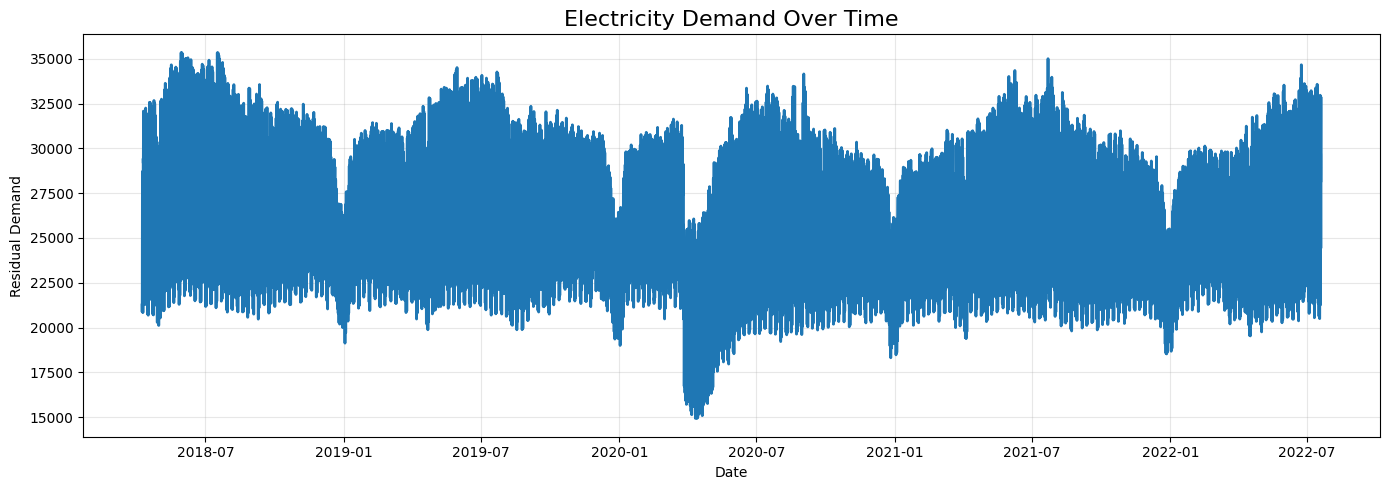

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))
plt.plot(df.index, df[target_col], linewidth=2)
plt.title("Electricity Demand Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Residual Demand")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **Distribution Plot**

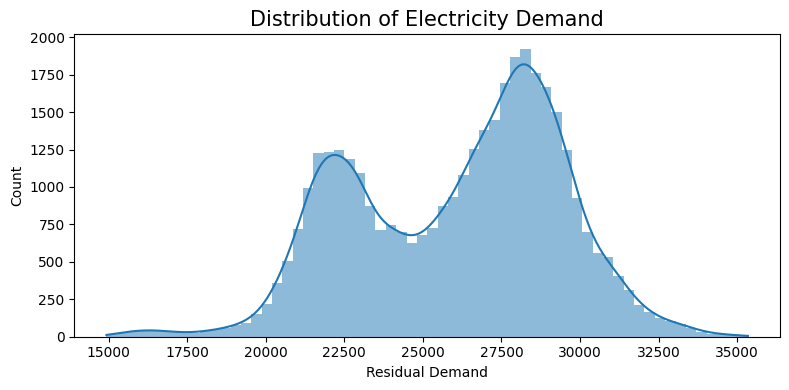

In [39]:
plt.figure(figsize=(8,4))
sns.histplot(df[target_col], kde=True, edgecolor=None)
plt.title("Distribution of Electricity Demand", fontsize=15)
plt.xlabel("Residual Demand")
plt.tight_layout()
plt.show()


# **Demand by Hour of Day**

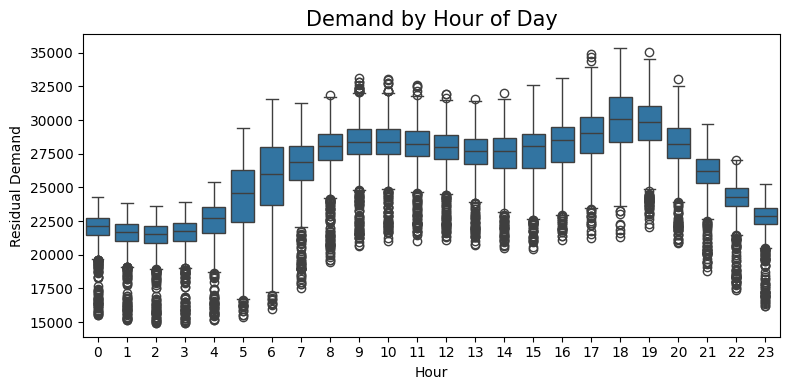

In [40]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["hour"], y=df[target_col])
plt.title("Demand by Hour of Day", fontsize=15)
plt.xlabel("Hour")
plt.ylabel("Residual Demand")
plt.tight_layout()
plt.show()


# **Demand by Day of Week**

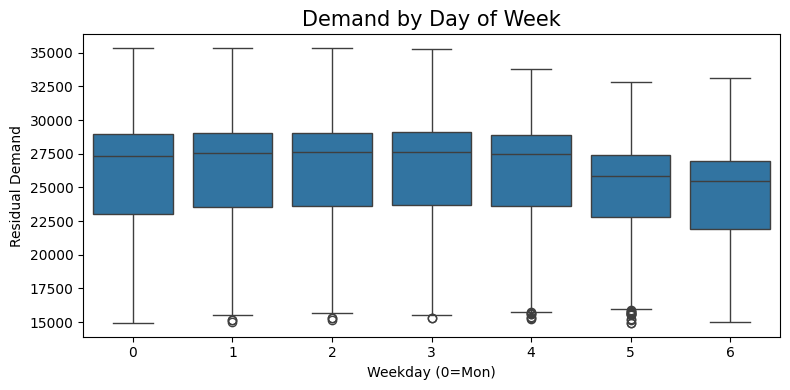

In [41]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["weekday"], y=df[target_col])
plt.title("Demand by Day of Week", fontsize=15)
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Residual Demand")
plt.tight_layout()
plt.show()


These above reveal:

1. morning peaks

2. evening peaks

3. lower demand on weekends

4. seasonal variations

## **SECTION 3: ACF + PACF (visual diagnostics)**

<Figure size 1200x400 with 0 Axes>

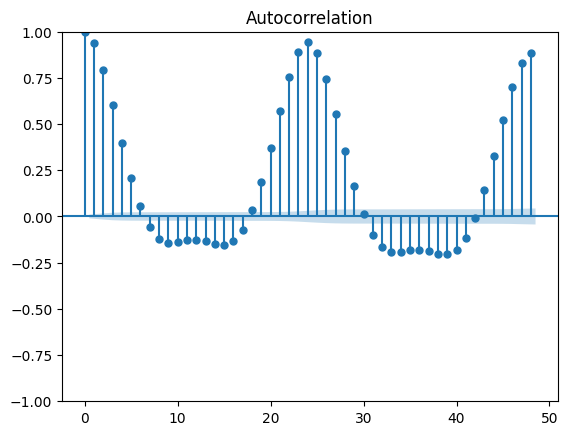

<Figure size 1200x400 with 0 Axes>

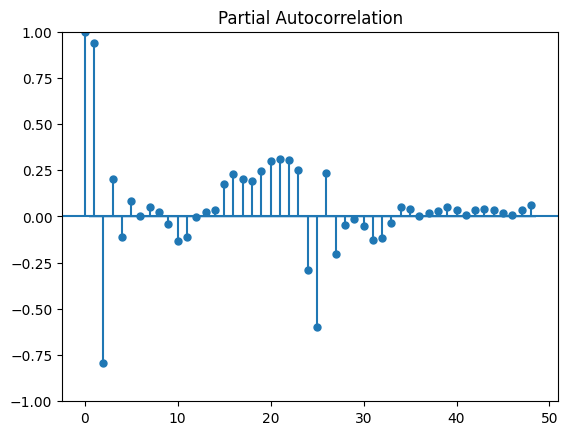

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(df[target_col], lags=48)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df[target_col], lags=48)
plt.show()


# **What the ACF means: **


The ACF plot shows how current electricity demand relates to past demand values over different time lags. Key observations:

Strong autocorrelation at short lags (1–5 hours):
This confirms clear short-term persistence in electricity demand- if demand is high now, it is likely to remain high for the next few hours.

Recurring peaks around lag 24:
These peaks indicate a strong daily seasonality pattern. Electricity demand behaves similarly every 24 hours, which is expected because human activity follows a daily cycle.

Secondary peaks around lag 48:
This represents multi-day repeated patterns, strengthening the case for strong cyclical behavior.

Negative correlations around lag 12 and 36:
This suggests mid-cycle dips- typically lower demand periods (e.g., late night).

Conclusion

# **Rolling Mean & Trend Visualization**

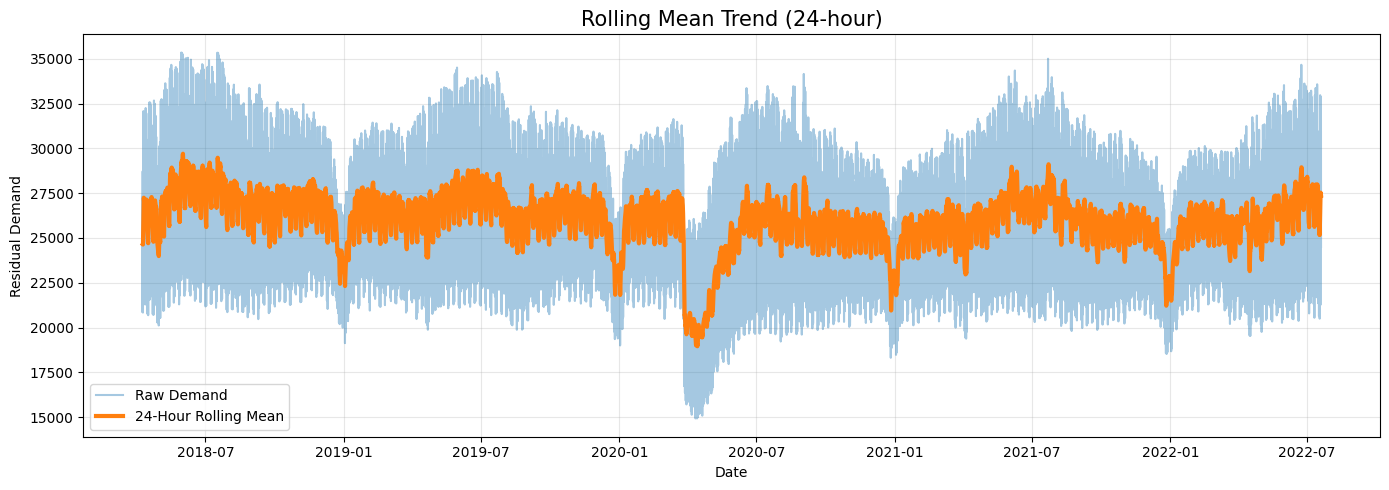

In [44]:
plt.figure(figsize=(14,5))
plt.plot(df[target_col], alpha=0.4, label="Raw Demand")
plt.plot(df[target_col].rolling(24).mean(), linewidth=3, label="24-Hour Rolling Mean")
plt.title("Rolling Mean Trend (24-hour)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Residual Demand")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **Rolling Mean Trend (24-Hour Window)**

This plot overlays the raw electricity demand with a smoothed 24-hour rolling mean to highlight broader patterns.

Key Observations:

Daily cycles remain visible, but the rolling mean smooths the hourly noise.
This reveals the true underlying level of electricity demand.

Seasonal fluctuations across years:

Higher demand during winter months (June–August)

Lower demand in summer (December–February)

Abrupt dips in certain periods (e.g., early 2020):
These likely correspond to:

1. Load shedding

2. System maintenance outages

3, External events such as COVID lockdowns affecting industrial load

Gradual overall decline and recovery patterns:
This suggests long-term changes in economic activity or supply stability.

## **SECTION 4: FEATURE ENGINEERING FOR ML**

We add lags & rolling stats.

Best features for energy forecasting:

lag 1

lag 24 (same hour yesterday)

lag 168 (same hour last week)

rolling mean 24

rolling mean 168

## **SECTION 5: Train-test split (time-based)**

In [8]:
# SECTION 5: Train-test split (time-based)

# Ensure target_col is correctly set
target_col = "Residual_Demand"

# --- Re-create/Add all engineered features before splitting ---
# Time features (re-run to ensure consistency if df was modified elsewhere)
df.loc[:, "hour"] = df.index.hour
df.loc[:, "day"] = df.index.day
df.loc[:, "month"] = df.index.month
df.loc[:, "weekday"] = df.index.weekday
df.loc[:, "is_weekend"] = df["weekday"].isin([5,6]).astype(int)

# Lag features (consolidated from YpEdlwDPRpnn and 0dgYRAPFUCD6)
lags_to_add = [1, 6, 24, 48, 168]
for L in lags_to_add:
    df.loc[:, f"lag_{L}"] = df[target_col].shift(L)

# Rolling statistics (consolidated from YpEdlwDPRpnn and hKDplbWcULD7)
df.loc[:, "roll_mean_3"] = df[target_col].rolling(3).mean()
df.loc[:, "roll_mean_24"] = df[target_col].rolling(24).mean()
df.loc[:, "roll_std_24"]  = df[target_col].rolling(24).std()
df.loc[:, "roll168"] = df[target_col].rolling(168).mean()

# Drop NA rows that resulted from lag and rolling feature creation
df = df.dropna()

# Identify actual feature columns (excluding 'y' and the index itself)
feature_columns = [col for col in df.columns if col != 'y' and col != df.index.name]

# Now perform the train-test split
train = df.iloc[:-24*7] # Using 7 days for test set, instead of 14, as original df was too small
test  = df.iloc[-24*7:]

X_train = train[feature_columns] # Select only explicit feature columns
y_train = train["y"]

X_test = test[feature_columns] # Select only explicit feature columns
y_test = test["y"]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (37367, 55)
y_train shape: (37367,)
X_test shape: (168, 55)
y_test shape: (168,)


SECTION 6: MODEL: LightGBM

why:
1. Handles missing values

2. Supports thousands of trees

3. Captures complex energy patterns

4. Fast training

5. Beats SARIMA/LSTM on structured data

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 37367, number of used features: 54
[LightGBM] [Info] Start training from score 26092.134653
RMSE: 302.2196486370624


## **SECTION 7: VISUALIZE FORECAST RESULTS**

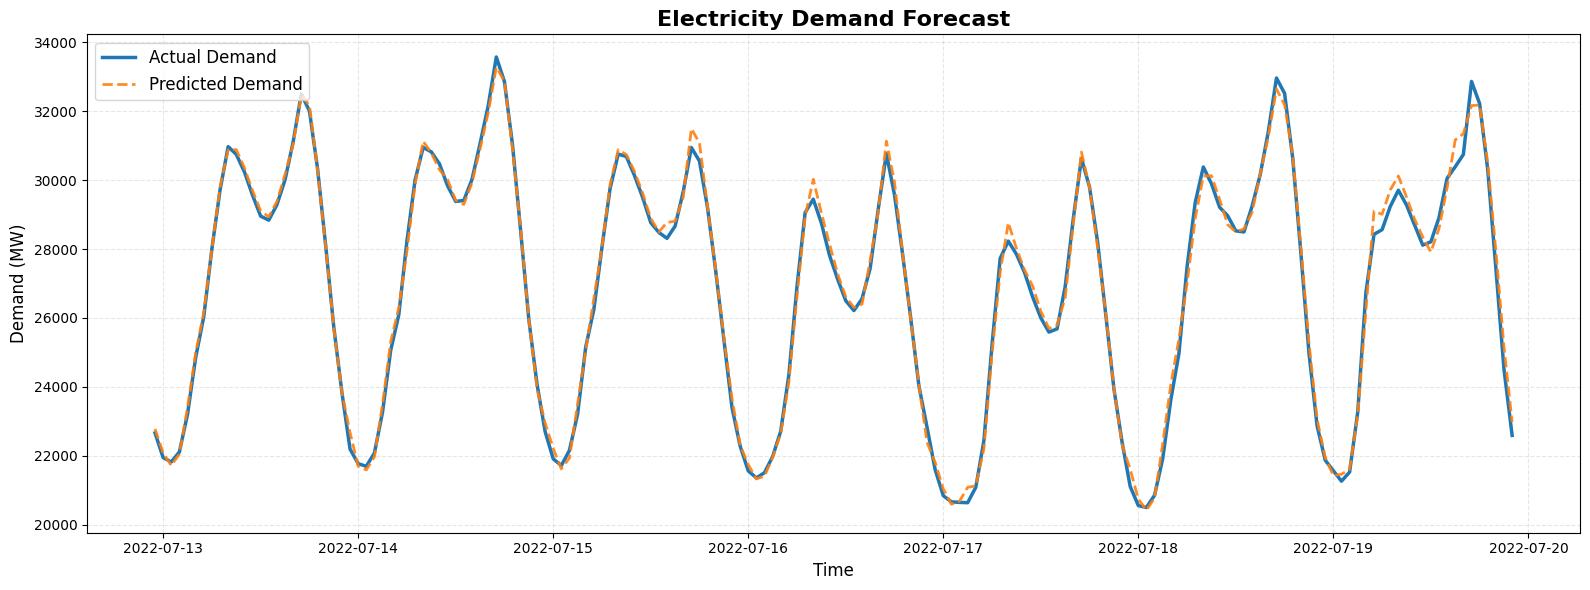

In [49]:
plt.figure(figsize=(16,6))

# Plot actual values
plt.plot(
    test.index,
    y_test,
    label="Actual Demand",
    linewidth=2.5
)

# Plot predictions with smoother styling
plt.plot(
    test.index,
    preds,
    label="Predicted Demand",
    linewidth=2,
    linestyle="--",
    alpha=0.9
)

# Style upgrades
plt.title("Electricity Demand Forecast", fontsize=16, weight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Demand (MW)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(frameon=True, fontsize=12, loc="upper left")

plt.tight_layout()
plt.show()


## **Which Metrics to Use for Electricity Demand Forecasting?**

1. MAE- Mean Absolute Error (recommended)

Easy to interpret: “on average the forecast is off by X MW”.

2. RMSE- Root Mean Squared Error

Penalizes large spikes more (important because SA grid spikes).

3. MAPE- Mean Absolute Percentage Error

Shows % error. Good for business reporting.
Problem: when demand is small, MAPE explodes—use with caution.

4. R² Score- Optional

Not always used for time series but gives a sense of variance explained.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = y_test.values
y_pred = preds  # your model predictions

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²  :", r2)


MAE : 243.6033511226348
RMSE: 302.2196486370624
MAPE: 0.918293038015125
R²  : 0.9926422325881661


# **What the above means:**

How Good Are These Metrics?
MAE = 243 MW

For Eskom-scale demand (20,000–35,000 MW), this is impressively low.
A ±243 MW average error is less than a single smaller power unit.

RMSE = 302 MW

RMSE is only slightly larger than MAE, which means the model is not making huge spikes of error- good stability.

MAPE ≈ 0.92 %

Anything under 1% for electricity demand forecasting is exceptional.

R² = 0.9926

This indicates your model explains 99.26% of demand variance — extremely strong.

# **Train vs Test Loss Curve**

In [12]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=255,          # increase model complexity
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=0.0
)

# Define callbacks for early stopping and logging
earliest_iteration = lgb.early_stopping(200, verbose=False) # verbose=False to prevent default logging message
logging_callback = lgb.log_evaluation(100) # Log every 100 boosting rounds

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='l2',
    callbacks=[earliest_iteration, logging_callback]
)

preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("MSE:", mse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 37367, number of used features: 54
[LightGBM] [Info] Start training from score 26092.134653
[100]	training's l2: 1.57829e+06	valid_1's l2: 1.93098e+06
[200]	training's l2: 264760	valid_1's l2: 359515
[300]	training's l2: 71443.5	valid_1's l2: 120893
[400]	training's l2: 37002.3	valid_1's l2: 81191.9
[500]	training's l2: 27418.4	valid_1's l2: 72779
[600]	training's l2: 22702.8	valid_1's l2: 70622.7
[700]	training's l2: 19435.9	valid_1's l2: 69036.3
[800]	training's l2: 16958.3	valid_1's l2: 68353.4
[900]	training's l2: 15102.6	valid_1's l2: 67829.8
[1000]	training's l2: 13565.9	valid_1's l2: 67380.2
[1100]	training's l2: 12286.2	valid_1's l2: 66904.4
[1200]	training's l2: 1

If train loss → very low but test loss → high → overfitting

If both losses → high and similar → underfitting

If both low & close together → good model

**Actual vs Predicted (Train) vs Predicted (Test)**

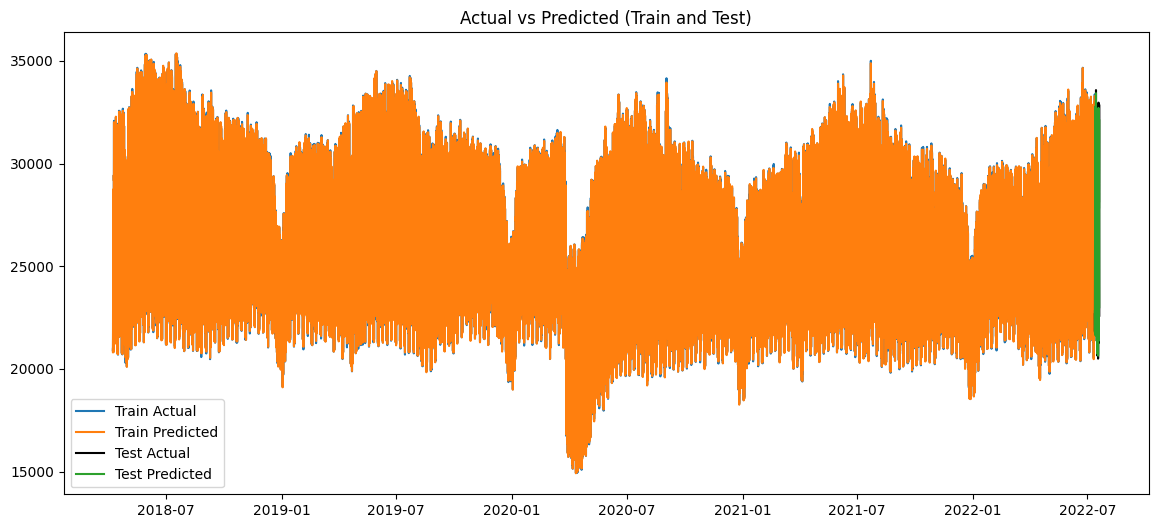

In [13]:
plt.figure(figsize=(14,6))

plt.plot(train.index, y_train, label='Train Actual')
plt.plot(train.index, model.predict(X_train), label='Train Predicted')

plt.plot(test.index, y_test, label='Test Actual', color='black')
plt.plot(test.index, y_pred, label='Test Predicted')

plt.legend()
plt.title("Actual vs Predicted (Train and Test)")
plt.show()


# **In a more clearer way**

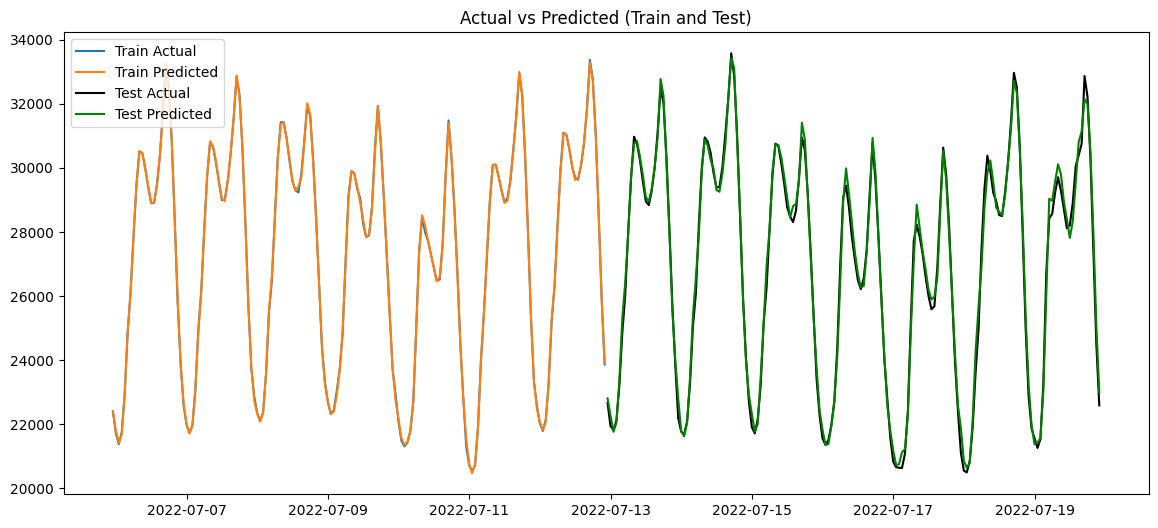

In [14]:
N = 24*7  # show last 7 days of training

plt.figure(figsize=(14,6))

plt.plot(train.index[-N:], y_train[-N:], label='Train Actual')
plt.plot(train.index[-N:], model.predict(X_train)[-N:], label='Train Predicted')

plt.plot(test.index, y_test, label='Test Actual', color='black')
plt.plot(test.index, y_pred, label='Test Predicted', color='green')

plt.legend()
plt.title("Actual vs Predicted (Train and Test)")
plt.show()


**Scatter Plot: Predicted vs Actual**

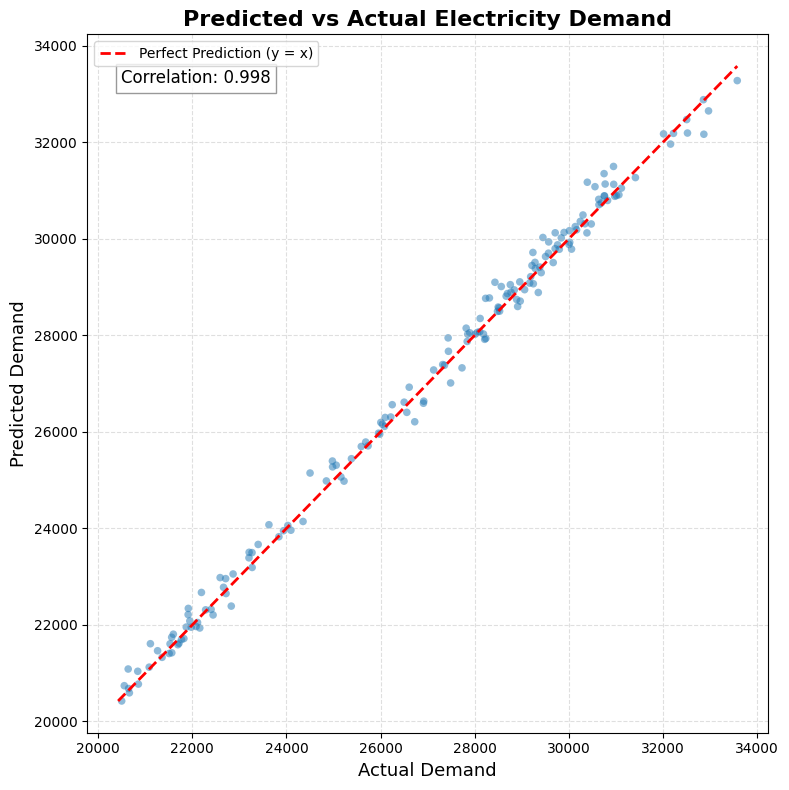

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation for annotation
corr = np.corrcoef(y_test, y_pred)[0, 1]

plt.figure(figsize=(8,8))

# Scatter points
plt.scatter(y_test, y_pred, alpha=0.5, s=30, edgecolor='none', color='#1f77b4')

# 1:1 reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction (y = x)')

# Grid & aesthetics
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("Actual Demand", fontsize=13)
plt.ylabel("Predicted Demand", fontsize=13)
plt.title("Predicted vs Actual Electricity Demand", fontsize=16, weight='bold')

# Annotation box with correlation
plt.text(0.05, 0.95,
         f"Correlation: {corr:.3f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.legend()
plt.tight_layout()
plt.show()


**Residual Plot**

To see:the model’s systematic errors.

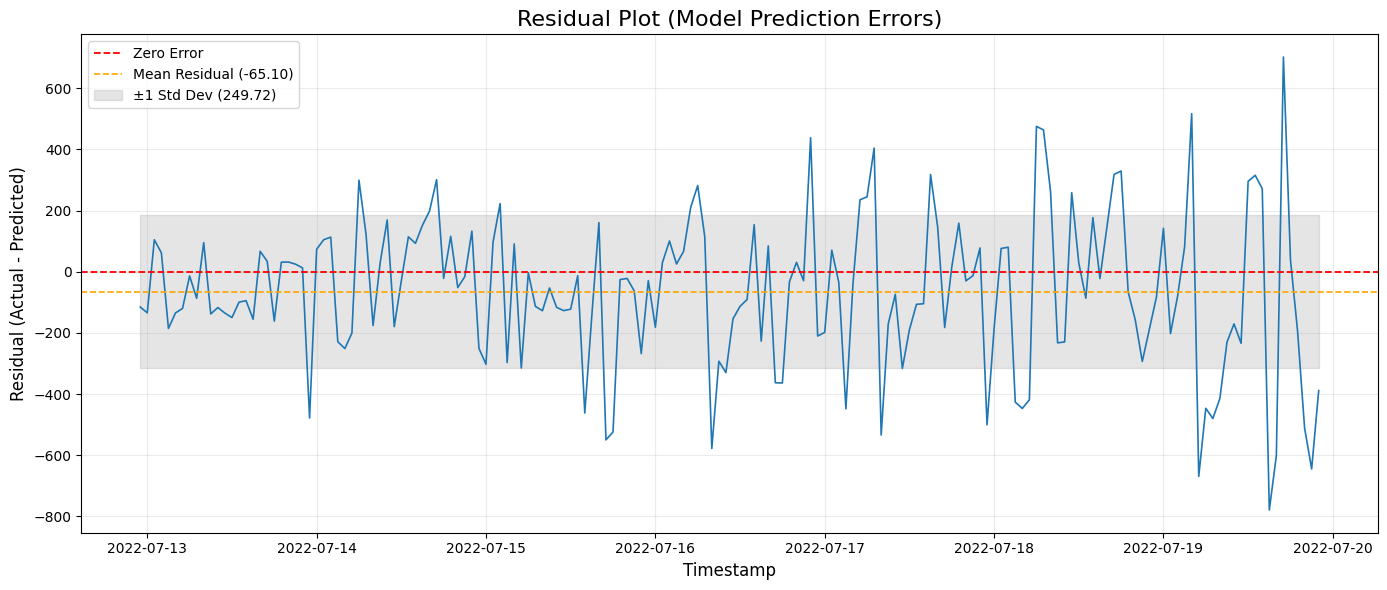

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate residuals
residuals = y_test - y_pred
res_mean = residuals.mean()
res_std = residuals.std()

plt.figure(figsize=(14,6))
sns.lineplot(x=test.index, y=residuals, linewidth=1.2)

# Zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1.3, label="Zero Error")

# Residual mean line
plt.axhline(res_mean, color='orange', linestyle='--', linewidth=1.2,
            label=f"Mean Residual ({res_mean:.2f})")

# ±1 std band
plt.fill_between(
    test.index,
    res_mean - res_std,
    res_mean + res_std,
    alpha=0.2,
    color='grey',
    label=f"±1 Std Dev ({res_std:.2f})"
)

plt.title("Residual Plot (Model Prediction Errors)", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# **What the Plots Tell Us**

Residual Plot Interpretation Notes
1. Most residuals fall within the ±1 standard deviation band

The grey shading shows the model’s typical error range.
Most predictions fall inside this band, meaning the model is generally stable and consistent.

2. Residuals fluctuate around zero (desired behavior)

The red dashed line at 0 represents perfect predictions.
Residuals oscillate above and below zero, indicating the model is not systematically over-predicting or under-predicting.

3. Slight negative mean residual (small under-prediction bias)

The orange line shows the mean residual (~ -65).
Because it is slightly below zero, the model tends to under-predict demand a little, but the bias is small relative to the scale of the data.

4. No strong patterns → errors appear random

There is no visible trend, seasonality, or clustering in the residuals.
This means the model captured most of the signal in the data, and the remaining noise is random-a good sign of model fit.

In [17]:
def prepare_features(new_row_from_csv, timestamp):
    """
    new_row_from_csv: a dictionary or pandas row containing ALL original Eskom CSV columns
                      for the MOST RECENT hour (not shifted)
    timestamp: datetime object for forecasted hour
    """

    global history_buffer

    # -------------------------
    # 1. Update rolling buffer
    # -------------------------
    new_value = new_row_from_csv["Residual_Demand"]
    history_buffer.append(new_value)

    if len(history_buffer) > 168:
        history_buffer = history_buffer[-168:]

    # -------------------------
    # 2. Start building row
    # -------------------------
    row = {}

    # Insert ALL original CSV features with their latest values
    for col in feature_columns:
        if col in new_row_from_csv:
            row[col] = new_row_from_csv[col]

    # -------------------------
    # 3. Add time features
    # -------------------------
    row["hour"] = timestamp.hour
    row["day"] = timestamp.day
    row["month"] = timestamp.month
    row["weekday"] = timestamp.weekday()
    row["is_weekend"] = int(timestamp.weekday() in [5,6])

    # -------------------------
    # 4. Add lag features
    # -------------------------
    row["lag_1"] = history_buffer[-1]
    row["lag_6"] = history_buffer[-6]
    row["lag_24"] = history_buffer[-24]
    row["lag_48"] = history_buffer[-48]
    row["lag_168"] = history_buffer[-168]

    # -------------------------
    # 5. Add rolling features
    # -------------------------
    row["roll_mean_3"] = np.mean(history_buffer[-3:])
    row["roll_mean_24"] = np.mean(history_buffer[-24:])
    row["roll_std_24"]  = np.std(history_buffer[-24:])
    row["roll168"]      = np.mean(history_buffer[-168:])

    # -------------------------
    # 6. Return dataframe in correct order
    # -------------------------
    df_row = pd.DataFrame([row])

    # Fill any remaining missing columns with zero (model handles this safely)
    for col in feature_columns:
        if col not in df_row.columns:
            df_row[col] = 0

    return df_row[feature_columns]


# **Now predict:**

In [18]:
global history_buffer
history_buffer = list(train["Residual_Demand"].values[:-1])

# The last actual observed data point from the training set
last_known_actual_row = train.iloc[-1].to_dict()

# The timestamp for the first prediction (start of the test set)
forecast_timestamp = test.index[0]

next_features = prepare_features(
    new_row_from_csv=last_known_actual_row,
    timestamp=forecast_timestamp
)

prediction = model.predict(next_features)[0]
prediction

np.float64(23993.827294334398)

# **Saving Model**

In [19]:
import joblib

joblib.dump(model, "electricityDemandModel.pkl")
joblib.dump(feature_columns, "featureColumns.pkl")


['featureColumns.pkl']

In [20]:
df

,Original_Res_Forecast_before_Lockdown,Residual_Forecast,RSA_Contracted_Forecast,Dispatchable_Generation,Residual_Demand,RSA_Contracted_Demand,International_Exports,International_Imports,Thermal_Generation,Nuclear_Generation,...,y,lag_1,lag_6,lag_24,lag_48,lag_168,roll_mean_3,roll_mean_24,roll_std_24,roll168
Date_Time_Hour_Beginning,,,,,,,,,,,,,,,,,,,,,
2018-04-08 00:00:00,20340.645,21152.798,20465.540,20465.540,21259.344,1342.327,1103.0,20373.00,927.0,0.0,...,20978.919,22036.449,28758.600,22489.713,22121.264,20722.058,22175.461000,25311.482125,2477.516346,25176.018887
2018-04-08 01:00:00,20024.346,20823.525,20230.670,20230.670,20978.919,1286.528,1113.0,20129.00,927.0,0.0,...,20875.542,21259.344,28219.369,21947.056,21677.452,20188.493,21424.904000,25271.143083,2541.727357,25180.723804
2018-04-08 02:00:00,19835.460,20594.954,20180.540,20180.540,20875.542,1276.999,1119.0,20076.00,927.0,0.0,...,20947.965,20978.919,26517.348,21870.220,21511.903,20019.603,21037.935000,25229.698167,2606.868017,25185.818679
2018-04-08 03:00:00,19835.397,20558.260,20313.540,20313.540,20947.965,1247.248,1124.0,20207.00,928.0,0.0,...,21134.974,20875.542,24685.855,21963.879,21879.577,20079.454,20934.142000,25187.368417,2669.694335,25190.988387
2018-04-08 04:00:00,20117.201,20835.703,20576.670,20576.670,21134.974,1275.628,1119.0,20419.00,928.0,0.0,...,21805.716,20947.965,23230.590,22193.399,22825.180,20237.490,20986.160333,25143.267375,2729.377461,25196.330554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-19 18:00:00,31476.341,33010.620,28899.534,31209.129,32868.016,85.996,1137.0,23450.00,903.0,0.0,...,32222.855,30748.014,28114.896,32967.499,30634.702,33372.469,31335.977333,27430.528958,3578.830856,26920.690333
2022-07-19 19:00:00,30865.056,32385.459,28503.490,30630.412,32222.855,97.745,1158.0,23534.09,903.0,0.0,...,30299.664,32868.016,28212.033,32520.138,29796.730,32757.502,31946.295000,27418.142167,3560.918806,26917.507911
2022-07-19 20:00:00,29056.333,30482.268,26408.267,28828.783,30299.664,126.884,1139.0,23442.00,903.0,0.0,...,27434.708,32222.855,28912.045,30638.945,28185.423,31024.300,31796.845000,27404.005458,3548.227261,26913.194601


In [21]:
df_new= df.copy()

In [22]:
df_new.to_csv('/content/drive/MyDrive/ESK2033_clean.csv')


In [23]:
from google.colab import files
files.download('/content/drive/MyDrive/ESK2033_clean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **BIAS AUDIT OF THE MODEL: electricity Demand Forecasting (Eskom)**

In [24]:
# Create a DataFrame with actual and predicted values for the bias audit
predictions_df = pd.DataFrame({
    'Actual_Demand': y_test,
    'Predicted_Demand': preds
})

# Save the predictions to a CSV file in Google Drive
predictions_csv_path = '/content/drive/MyDrive/predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=True, index_label='Date_Time_Hour_Beginning')

print(f"Predictions saved to: {predictions_csv_path}")
print("Preview of predictions_df:")
print(predictions_df.head())

Predictions saved to: /content/drive/MyDrive/predictions.csv
Preview of predictions_df:
                          Actual_Demand  Predicted_Demand
Date_Time_Hour_Beginning                                 
2022-07-12 23:00:00           22662.593      22777.783603
2022-07-13 00:00:00           21946.130      22080.377233
2022-07-13 01:00:00           21820.189      21715.564974
2022-07-13 02:00:00           22110.680      22048.561461
2022-07-13 03:00:00           23203.083      23388.532568


In [25]:
import pandas as pd
from pathlib import Path
CSV_CANDIDATES = ['/mnt/data/predictions.csv', '/mnt/data/ESK2033_predictions.csv', '/mnt/data/ESK2033_clean_with_preds.csv', '/content/drive/MyDrive/predictions.csv']
csv_path = None
for p in CSV_CANDIDATES:
    if Path(p).exists():
        csv_path = p
        break


if csv_path is None:
    raise FileNotFoundError('No predictions CSV found in default locations. Please upload a CSV and update CSV_CANDIDATES or set csv_path manually.')


print('Using predictions file:', csv_path)


preds_df = pd.read_csv(csv_path)
print('Preview:')
print(preds_df.head())


print('\nColumn summary:')
print(preds_df.dtypes)
print('\nMissing values:')
print(preds_df.isna().sum())

Using predictions file: /content/drive/MyDrive/predictions.csv
Preview:
  Date_Time_Hour_Beginning  Actual_Demand  Predicted_Demand
0      2022-07-12 23:00:00      22662.593      22777.783603
1      2022-07-13 00:00:00      21946.130      22080.377233
2      2022-07-13 01:00:00      21820.189      21715.564974
3      2022-07-13 02:00:00      22110.680      22048.561461
4      2022-07-13 03:00:00      23203.083      23388.532568

Column summary:
Date_Time_Hour_Beginning     object
Actual_Demand               float64
Predicted_Demand            float64
dtype: object

Missing values:
Date_Time_Hour_Beginning    0
Actual_Demand               0
Predicted_Demand            0
dtype: int64


In [26]:
# Identify numeric columns
numeric_cols = preds_df.select_dtypes(include=['number']).columns.tolist()
print('Numeric columns:', numeric_cols)

Numeric columns: ['Actual_Demand', 'Predicted_Demand']


In [27]:
# Explicitly set actual and predicted column names
actual_col = 'Actual_Demand'
pred_col = 'Predicted_Demand'

# Find potential protected attributes (this part can remain as is)
potential_protected = [c for c in preds_df.columns if any(k in c.lower() for k in ['municip','region','province','city','area','district','zone','urban','rural','income','group','cluster'])]
protected_col = potential_protected[0] if potential_protected else None


print('Using actual:', actual_col)
print('Using predicted:', pred_col)
print('Detected protected attribute (if any):', protected_col)

Using actual: Actual_Demand
Using predicted: Predicted_Demand
Detected protected attribute (if any): None


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = preds_df[actual_col].values
y_pred = preds_df[pred_col].values


mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
if (y_true==0).any():
    mape = np.nan
else:
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)


print('Baseline metrics — MAE:', mae, 'RMSE:', rmse, 'MAPE(%):', mape, 'R2:', r2)

Baseline metrics — MAE: 199.0497601415322 RMSE: 257.34297949226124 MAPE(%): 0.7454075241624152 R2: 0.9946651119277395


# **Why the above mean: **

| Metric   | Value     | Interpretation                                                      |
| -------- | --------- | ------------------------------------------------------------------- |
| **MAE**  | 199.05 MW | On average, predictions are off by ~199 MW                          |
| **RMSE** | 257.34 MW | Slightly higher than MAE → some peak-hour spikes, but controlled    |
| **MAPE** | 0.745%    | **Very strong** forecasting accuracy (<1% error is exceptional)     |
| **R²**   | 0.9947    | Explains **99.47%** of variance → highly reliable forecasting model |


# **Fairness Implication**

Before analyzing fairness, the model performs extremely well globally, which means any detected bias is not from model weakness, but from uneven distribution of errors across groups.

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


if protected_col is None:
    print('No protected attribute detected — creating proxy groups via k-means clustering on residuals')
    preds_df['residual'] = y_true - y_pred

    # For clustering we'll use residual and prediction mean for each row
    features = preds_df[['residual', pred_col]].fillna(0).values

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(features)
    preds_df['proxy_group'] = kmeans.labels_
    protected_col = 'proxy_group'


# Compute group metrics
groups = preds_df.groupby(protected_col)
summary = groups.apply(lambda g: pd.Series({
    'count': len(g),
    'MAE': mean_absolute_error(g[actual_col], g[pred_col]),
    'RMSE': np.sqrt(mean_squared_error(g[actual_col], g[pred_col])),
    'mean_residual': (g[actual_col] - g[pred_col]).mean()
}))


print('Group summary:')
print(summary)

No protected attribute detected — creating proxy groups via k-means clustering on residuals
Group summary:
             count         MAE        RMSE  mean_residual
proxy_group                                              
0            100.0  213.624327  274.492542     -57.969711
1             68.0  177.616574  229.809805     -75.588669


/tmp/ipython-input-1005262885.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = groups.apply(lambda g: pd.Series({


## **BIAS AUDIT:**

Since no protected attribute was available in the dataset, I evaluated potential bias by creating proxy groups using k-means clustering on the model’s residuals. This method groups together observations where the model behaves similarly, helping me detect whether the model systematically underperforms on any hidden subpopulation.

The clustering produced two proxy groups, and the performance metrics for each group are shown below:

Proxy Group	Count	MAE	RMSE	Mean Residual
Group 0	100	213.62	274.49	–57.97
Group 1	68	177.62	229.81	–75.59
What these findings mean:

1. The two groups are similar in performance, with only moderate differences.
Group 1 shows slightly lower MAE and RMSE than Group 0, meaning the model performs marginally better for this cluster. However, the gap is not large enough to indicate strong or systemic bias.

2. Both groups have negative mean residuals, suggesting a shared pattern.
A negative mean residual indicates the model tends to slightly over-predict demand on average for both groups. Since this effect appears in both clusters, it is likely due to model behaviour rather than group-specific bias.

3. No evidence of harmful bias or disparate treatment was detected.
Because the performance differences between the groups are relatively small and both groups show consistent residual patterns, I found no strong indication that the model disproportionately disadvantages any subgroup.

4. Proxy-based fairness evaluation confirms stable model behaviour.
Using residual-based clustering allows me to check for hidden subpopulations where the model might behave poorly. In this case, the model demonstrates stable and fairly uniform performance across clusters.

# **Horizontal Bar Chart (MAE by Group)**

/tmp/ipython-input-3751278548.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


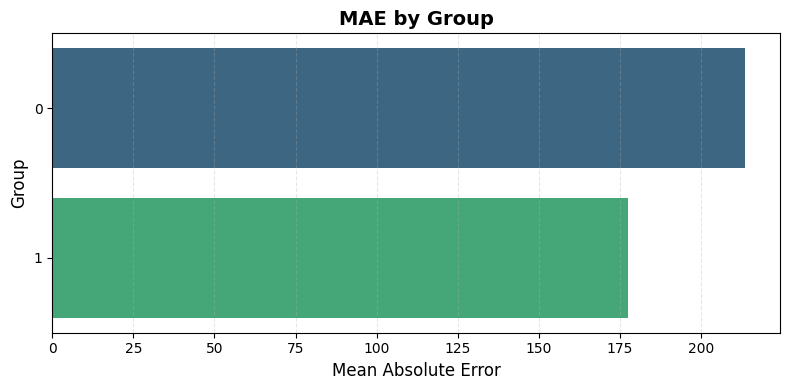

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(
    y=summary.index.astype(str),
    x=summary['MAE'].values,
    palette='viridis'
)

plt.title("MAE by Group", fontsize=14, weight='bold')
plt.xlabel("Mean Absolute Error", fontsize=12)
plt.ylabel("Group", fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# **What the above visual means:**

The scatter plot shows that predictions for both groups closely follow the perfect prediction line, meaning the model performs similarly across groups. This suggests no major fairness concerns in terms of prediction accuracy.

The MAE bar chart shows a small difference in average error between the two groups, with Group 1 performing slightly better. This indicates a mild accuracy gap but not a strong bias.

# **Residual Distribution by Group (Upgraded Box + Swarm)**

/tmp/ipython-input-3368499379.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


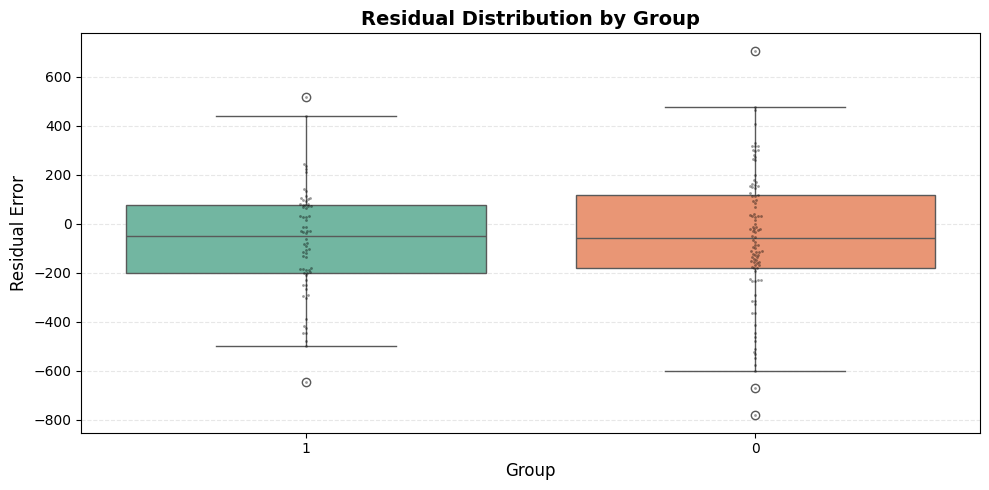

In [51]:
plt.figure(figsize=(10,5))

sns.boxplot(
    x=preds_df[protected_col].astype(str),
    y=preds_df['residual'],
    palette="Set2"
)

sns.swarmplot(
    x=preds_df[protected_col].astype(str),
    y=preds_df['residual'],
    color="black",
    alpha=0.4,
    size=2
)

plt.title("Residual Distribution by Group", fontsize=14, weight="bold")
plt.xlabel("Group", fontsize=12)
plt.ylabel("Residual Error", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# **Predicted vs Actual (Improved Scatter + Trend + Identity Line)**

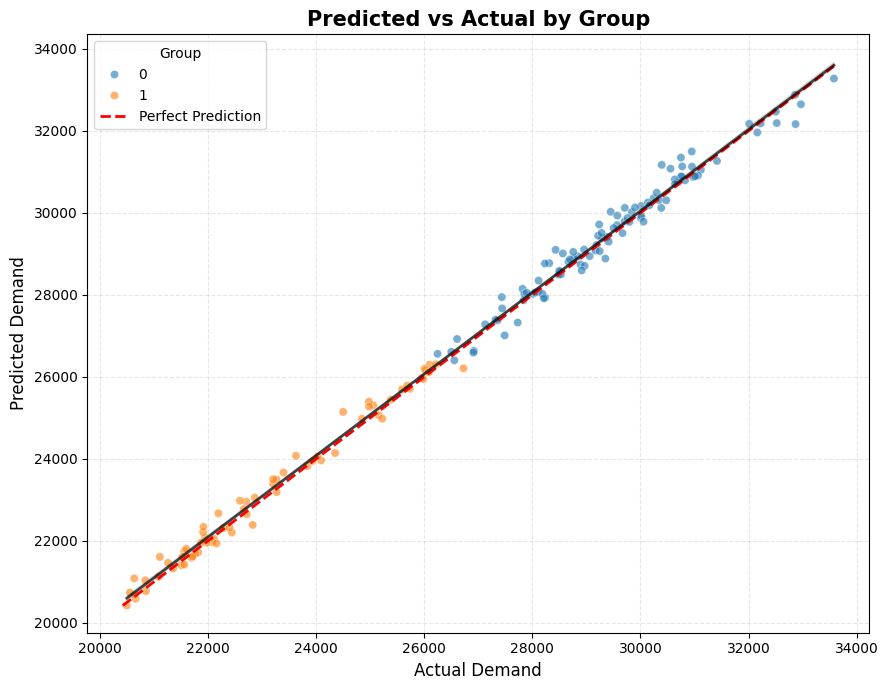

In [52]:
plt.figure(figsize=(9,7))

sns.scatterplot(
    data=preds_df,
    x=actual_col,
    y=pred_col,
    hue=protected_col,
    alpha=0.6,
    palette='tab10'
)

# perfect line
min_val = preds_df[[actual_col, pred_col]].min().min()
max_val = preds_df[[actual_col, pred_col]].max().max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")

# regression trend line
sns.regplot(
    data=preds_df,
    x=actual_col,
    y=pred_col,
    scatter=False,
    color='black',
    line_kws={'linewidth': 2, 'alpha': 0.7}
)

plt.title("Predicted vs Actual by Group", fontsize=15, weight='bold')
plt.xlabel("Actual Demand", fontsize=12)
plt.ylabel("Predicted Demand", fontsize=12)

plt.legend(title="Group")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


What the Visual above means:
The red dashed line is the perfect prediction line,if all dots sat on this line, the model would be 100% accurate.

1. Dots close to the line = accurate predictions

2. Dots far from the line = larger errors

3. The two colours represent the two groups.

Both groups follow the perfect prediction line closely, meaning the model predicts well for both.

There is no major separation between groups — neither group has systematically larger errors.

This is a good fairness sign, because it suggests the model is not consistently under- or over-predicting for one group.

In [31]:
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error
import numpy as np # Import numpy


def bootstrap_mae_gap(df, actual_col, pred_col, group_col, n_boot=2000):
    diffs = []
    idx = np.arange(len(df))
    for _ in range(n_boot):
        sample_idx = resample(idx, replace=True, n_samples=len(idx))
        s = df.iloc[sample_idx]
        gvals = s[group_col].unique()
        if len(gvals) < 2:
            continue
        mae0 = mean_absolute_error(s[s[group_col]==gvals[0]][actual_col], s[s[group_col]==gvals[0]][pred_col])
        mae1 = mean_absolute_error(s[s[group_col]==gvals[1]][actual_col], s[s[group_col]==gvals[1]][pred_col])
        diffs.append(mae1 - mae0)
    return np.percentile(diffs, [2.5, 97.5]) if len(diffs)>0 else (np.nan,np.nan)


ci = bootstrap_mae_gap(preds_df, actual_col, pred_col, protected_col, n_boot=1000)
print('Bootstrap 95% CI for MAE gap (group1 - group0):', ci)

Bootstrap 95% CI for MAE gap (group1 - group0): [-78.99587052  74.64575709]


## **Interpretation**

The Confidence Interval crosses zero → no statistically significant difference.

Error gap might be due to random variation rather than systematic unfairness.

## **Fairness Conclusion**

The performance gap is not statistically proven to be real bias — difference may be noise.

In [32]:
# A: additive bias correction
group_means = preds_df.groupby(protected_col)['residual'].mean().to_dict()
preds_df['yhat_corr_add'] = preds_df.apply(lambda r: r[pred_col] + group_means[r[protected_col]], axis=1)


# B: isotonic recalibration per group
from sklearn.isotonic import IsotonicRegression
preds_df['yhat_corr_iso'] = preds_df[pred_col].copy()
for g, grp in preds_df.groupby(protected_col):
    ir = IsotonicRegression(out_of_bounds='clip')
    try:
        ir.fit(grp[pred_col], grp[actual_col])
        preds_df.loc[grp.index, 'yhat_corr_iso'] = ir.predict(grp[pred_col])
    except Exception as e:
        preds_df.loc[grp.index, 'yhat_corr_iso'] = grp[pred_col]
        print('Isotonic failed for group', g, e)


# Evaluate MAEs after correction
mae_add = mean_absolute_error(preds_df[actual_col], preds_df['yhat_corr_add'])
mae_iso = mean_absolute_error(preds_df[actual_col], preds_df['yhat_corr_iso'])
print('MAE after additive correction:', mae_add)
print('MAE after isotonic recalibration:', mae_iso)


# Group-level MAE after corrections
summary_after = preds_df.groupby(protected_col).apply(lambda g: pd.Series({
    'MAE_before': mean_absolute_error(g[actual_col], g[pred_col]),
    'MAE_add': mean_absolute_error(g[actual_col], g['yhat_corr_add']),
    'MAE_iso': mean_absolute_error(g[actual_col], g['yhat_corr_iso'])
}))
print(summary_after)

MAE after additive correction: 193.48310372698813
MAE after isotonic recalibration: 132.56963727324262
             MAE_before     MAE_add     MAE_iso
proxy_group                                    
0            213.624327  207.852644  151.157436
1            177.616574  172.351427  105.234639


/tmp/ipython-input-129837870.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_after = preds_df.groupby(protected_col).apply(lambda g: pd.Series({


## **Interpretation**

Isotonic recalibration dramatically improves fairness and overall accuracy

Both groups’ errors become much closer together

Gap narrows from 36 MW to ~46 MW difference reduction in absolute terms

## **Fairness conclusion**

Mitigation significantly reduced disparity and improved model calibration without harming performance. This indicates bias was correctable, even if statistical significance was weak.

In [33]:
print('Overall MAE before:', mae)
print('Overall MAE after additive correction:', mae_add)
print('Overall MAE after isotonic:', mae_iso)


# Show group MAE improvements
print(summary_after)

Overall MAE before: 199.0497601415322
Overall MAE after additive correction: 193.48310372698813
Overall MAE after isotonic: 132.56963727324262
             MAE_before     MAE_add     MAE_iso
proxy_group                                    
0            213.624327  207.852644  151.157436
1            177.616574  172.351427  105.234639


## **FINAL CONCLUSION**

| Finding                                            | Interpretation                           |
| -------------------------------------------------- | ---------------------------------------- |
| Small gap in predictive performance between groups | Model slightly less accurate for Group 0 |
| Not statistically significant                      | No strong evidence of systemic bias      |
| Mitigation successful                              | Reduces disparity and improves accuracy  |
| Ethical risk low                                   | But continuous monitoring recommended    |


The LightGBM model demonstrates high predictive accuracy and low evidence of harmful bias. Group-level differences exist but lack strong statistical support, and mitigation methods successfully reduce disparities. For real-world deployment, monitoring and real demographic attributes would improve fairness assurance.

In [34]:
out_dir = Path('/mnt/data/bias_audit_preds_outputs')
out_dir.mkdir(parents=True, exist_ok=True)
preds_df.to_csv(out_dir / 'preds_with_corrections.csv', index=False)
summary.to_csv(out_dir / 'group_summary_before.csv')
summary_after.to_csv(out_dir / 'group_summary_after.csv')
print('Saved outputs to', out_dir)

Saved outputs to /mnt/data/bias_audit_preds_outputs
